In [ ]:
!pip install split-folders
!pip install gdown

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gdown
import splitfolders
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

In [ ]:
shutil.rmtree("SkinDisease", ignore_errors=True)
shutil.rmtree("skin_dataset", ignore_errors=True)

In [ ]:
file_id = "1NZTookxlFKAU371O3SW4KG41doDAKZej"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1NZTookxlFKAU371O3SW4KG41doDAKZej
From (redirected): https://drive.google.com/uc?id=1NZTookxlFKAU371O3SW4KG41doDAKZej&confirm=t&uuid=d047c280-66cf-42e2-9270-db218cabdd7f
To: /content/dataset.zip
100%|██████████| 2.49G/2.49G [00:18<00:00, 133MB/s]


'dataset.zip'

In [ ]:
!unzip -q dataset.zip -d skin_dataset

In [ ]:
splitfolders.ratio(
    input="skin_dataset",           # Folder hasil unzip
    output="SkinDisease",           # Folder output untuk split
    seed=42,
    ratio=(0.7, 0.3),               # 70% train, 30% test
    move=False                      # Copy, bukan pindah file
)
os.rename("SkinDisease/val", "SkinDisease/test")

Copying files: 39129 files [00:20, 1907.72 files/s]


In [ ]:
train_dir = "SkinDisease/train"
test_dir = "SkinDisease/test"

In [ ]:
def count_images_per_split(split_path):
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            print(f"{cls}: {count}")
            total += count
    print(f"Total: {total}")

print("=== TRAIN ===")
count_images_per_split("SkinDisease/train")
print("\n=== TEST ===")
count_images_per_split("SkinDisease/test")

=== TRAIN ===
Warts: 1247
Rosacea: 1220
Vasculitis: 1241
Sun_Sunlight_Damage: 1210
Unknown_Normal: 1284
Vitiligo: 1250
Candidiasis: 1205
Eczema: 1273
Infestations_Bites: 1229
DrugEruption: 1284
Actinic_Keratosis: 1253
Psoriasis: 1253
Moles: 1222
Vascular_Tumors: 1233
SkinCancer: 1248
Bullous: 1232
Seborrh_Keratoses: 1225
Acne: 1288
Tinea: 1273
Lupus: 1202
Lichen: 1234
Benign_tumors: 1274
Total: 27380

=== TEST ===
Warts: 535
Rosacea: 524
Vasculitis: 533
Sun_Sunlight_Damage: 519
Unknown_Normal: 551
Vitiligo: 537
Candidiasis: 517
Eczema: 546
Infestations_Bites: 528
DrugEruption: 551
Actinic_Keratosis: 537
Psoriasis: 538
Moles: 524
Vascular_Tumors: 529
SkinCancer: 535
Bullous: 528
Seborrh_Keratoses: 526
Acne: 552
Tinea: 546
Lupus: 516
Lichen: 530
Benign_tumors: 547
Total: 11749


In [ ]:
classes = [
    "Acne", "Actinic Keratosis", "Benign Tumors", "Bullous", "Candidiasis",
    "Drug Eruption", "Eczema", "Infestations/Bites", "Lichen", "Lupus",
    "Moles", "Psoriasis", "Rosacea", "Seborrheic Keratoses", "Skin Cancer",
    "Sun/Sunlight Damage", "Tinea", "Vascular Tumors", "Vasculitis", "Vitiligo",
    "Warts"
]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 21914 images belonging to 22 classes.
Found 5466 images belonging to 22 classes.
Found 11749 images belonging to 22 classes.


In [ ]:
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {val_generator.samples}")
print(f"Number of testing samples: {test_generator.samples}")

Number of training samples: 21914
Number of validation samples: 5466
Number of testing samples: 11749


In [ ]:
def show_images(generator, classes, num_images=8):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(classes[np.argmax(labels[i])])
        axes[i].axis('off')
    plt.show()

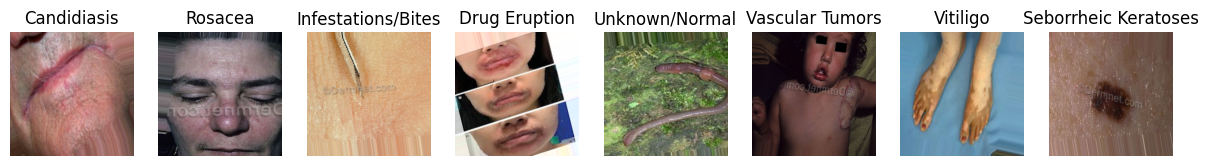

In [ ]:
show_images(train_generator, classes)

In [ ]:
# def residual_block(x, filters, stride=1, use_dropout=False):
#     shortcut = x
#     x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     if use_dropout:
#         x = layers.Dropout(0.5)(x)
#     if shortcut.shape[-1] != filters or stride != 1:
#         shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
#     x = layers.add([x, shortcut])
#     x = layers.ReLU()(x)
#     return x

In [ ]:
# def build_resnet(input_shape=(224, 224, 3), num_classes=22, use_dropout=False):
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
#     x = residual_block(x, 64, stride=1, use_dropout=use_dropout)
#     x = residual_block(x, 128, stride=2, use_dropout=use_dropout)
#     x = residual_block(x, 256, stride=2, use_dropout=use_dropout)
#     x = residual_block(x, 512, stride=2, use_dropout=use_dropout)
#     x = layers.GlobalAveragePooling2D()(x)
#     if use_dropout:
#         x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)
#     model = models.Model(inputs, outputs)
#     return model

In [ ]:
# model = build_resnet(num_classes=22, use_dropout=True)
# model.compile(
#     optimizer=optimizers.Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True,
    baseline=0.90
)

callbacks = [reduce_lr, checkpoint, early_stopping]

In [ ]:
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,117,910 (92.00 MB)

 Trainable params: 24,064,790 (91.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6319 - loss: 1.3613
Epoch 1: val_accuracy improved from -inf to 0.05104, saving model to best_model.h5


685/685 ━━━━━━━━━━━━━━━━━━━━ 476s 602ms/step - accuracy: 0.6320 - loss: 1.3608 - val_accuracy: 0.0510 - val_loss: 5.9148 - learning_rate: 1.0000e-04
Epoch 2/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.7847 - loss: 0.7392
Epoch 2: val_accuracy improved from 0.05104 to 0.74351, saving model to best_model.h5


685/685 ━━━━━━━━━━━━━━━━━━━━ 383s 558ms/step - accuracy: 0.7847 - loss: 0.7392 - val_accuracy: 0.7435 - val_loss: 0.9889 - learning_rate: 1.0000e-04
Epoch 3/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8107 - loss: 0.6412
Epoch 3: val_accuracy improved from 0.74351 to 0.76692, saving model to best_model.h5


685/685 ━━━━━━━━━━━━━━━━━━━━ 380s 554ms/step - accuracy: 0.8107 - loss: 0.6412 - val_accuracy: 0.7669 - val_loss: 0.9743 - learning_rate: 1.0000e-04
Epoch 4/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8321 - loss: 0.5587
Epoch 4: val_accuracy improved from 0.76692 to 0.76802, saving model to best_model.h5


685/685 ━━━━━━━━━━━━━━━━━━━━ 379s 553ms/step - accuracy: 0.8321 - loss: 0.5587 - val_accuracy: 0.7680 - val_loss: 1.0146 - learning_rate: 1.0000e-04
Epoch 5/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8535 - loss: 0.4971
Epoch 5: val_accuracy improved from 0.76802 to 0.76985, saving model to best_model.h5


685/685 ━━━━━━━━━━━━━━━━━━━━ 376s 548ms/step - accuracy: 0.8535 - loss: 0.4971 - val_accuracy: 0.7698 - val_loss: 0.9652 - learning_rate: 1.0000e-04
Epoch 6/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8655 - loss: 0.4438
Epoch 6: val_accuracy did not improve from 0.76985
685/685 ━━━━━━━━━━━━━━━━━━━━ 376s 548ms/step - accuracy: 0.8655 - loss: 0.4438 - val_accuracy: 0.7686 - val_loss: 1.0347 - learning_rate: 1.0000e-04
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 5.


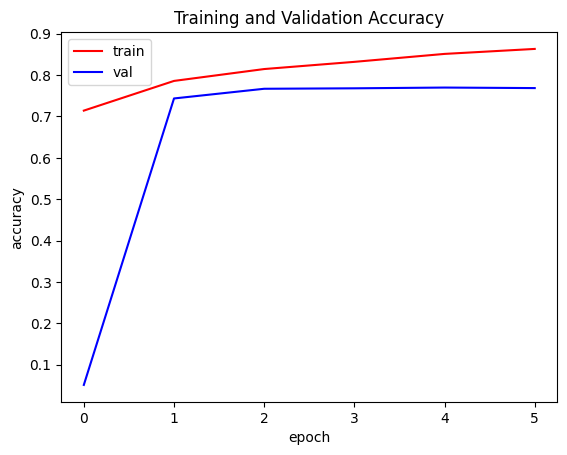

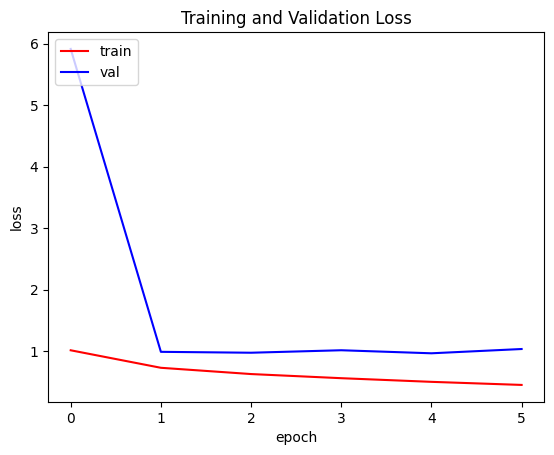

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("resnet_model.h5")
print("Model saved as resnet_model.h5")

Model saved as resnet_model.h5


In [ ]:
model = tf.keras.models.load_model("best_model.h5")
print("Model loaded successfully")

Model loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


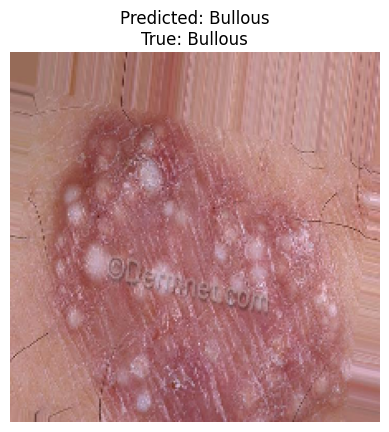

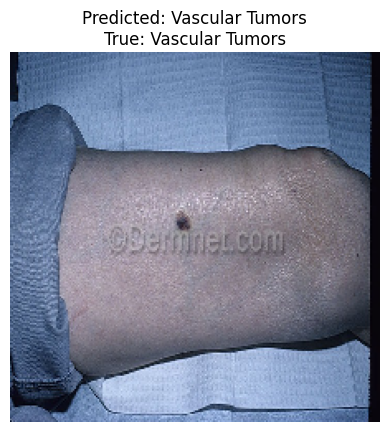

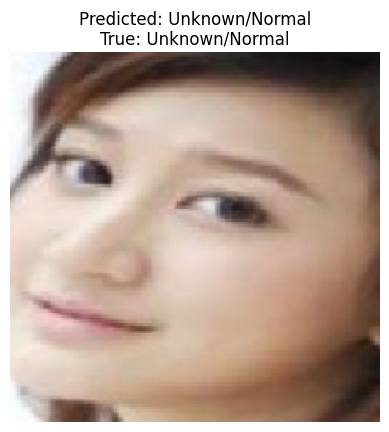

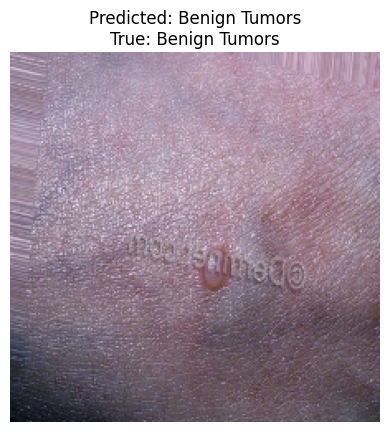

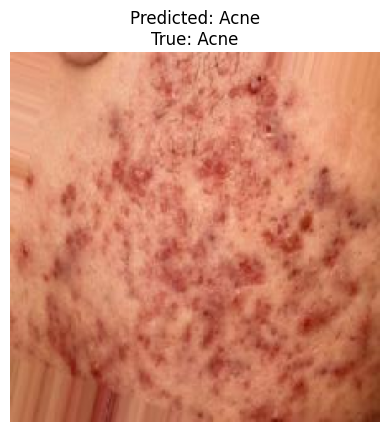

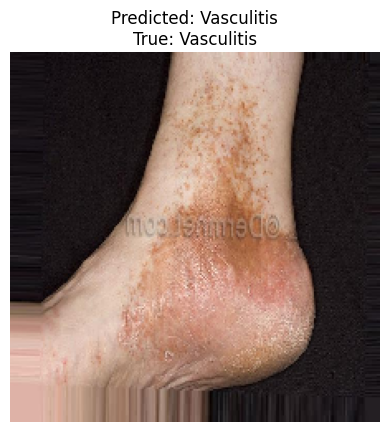

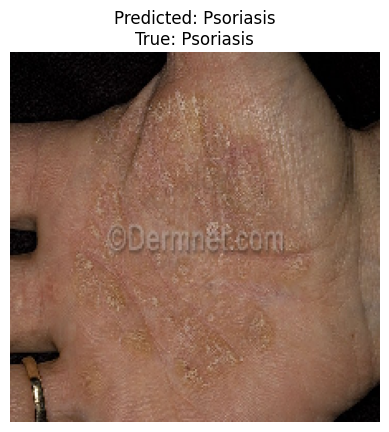

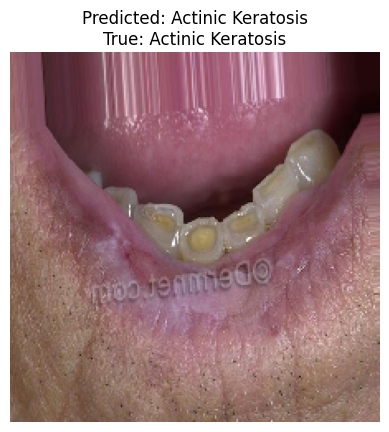

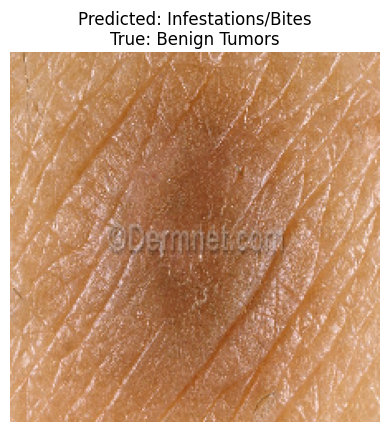

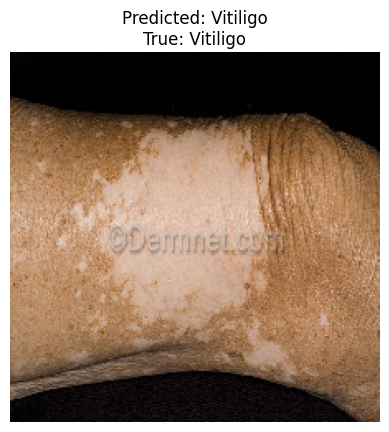

In [ ]:
def predict_and_show(model, generator, class_names, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images[:num_images])
    for i in range(num_images):
        plt.imshow(images[i])
        plt.title(f"Predicted: {class_names[np.argmax(predictions[i])]}\nTrue: {class_names[np.argmax(labels[i])]}" )
        plt.axis('off')
        plt.show()

predict_and_show(model, test_generator, classes, num_images=10)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%")

368/368 ━━━━━━━━━━━━━━━━━━━━ 61s 151ms/step - accuracy: 0.8066 - loss: 0.6931
Accuracy on the test set: 79.76%


In [ ]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(test_generator.classes, preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds,
    target_names=classes,
    digits=4
))

Confusion Matrix:
[[27 20 26 16 17 25 56 29 13 20 21 25 30 28 27 21 27 33 23 22 24 22]
 [24 20 28 20 29 27 53 28 19 28 17 17 22 23 17 20 44 14 22 20 24 21]
 [27 18 18 18 22 28 42 32 20 21 21 21 19 22 26 19 25 20 25 33 31 39]
 [23 13 17 19 21 29 65 22 12 19 23 18 12 18 38 21 40 18 17 33 31 19]
 [18 17 25 24 24 31 38 29 19 17 23 16 23 23 28 14 35 19 19 24 20 31]
 [21 17 19 23 23 27 43 28 27 26 15 21 16 21 22 29 44 19 29 32 26 23]
 [23 13 26 21 20 26 55 41 20 25 20 19 21 25 25 18 34 22 26 23 26 17]
 [18 15 23 22 26 26 54 22 19 25 22 18 16 15 31 26 43 12 18 21 31 25]
 [24 15 18 20 20 28 54 26 18 11 23 25 28 15 21 27 21 16 28 27 42 23]
 [19 19 23 15 14 31 61 28 13 20 21 17 14 18 28 21 30 21 27 29 27 20]
 [22 14 19 19 18 17 50 35 24 20 24 19 25 22 15 22 36 22 23 30 21 27]
 [19 13 23 20 17 30 48 26 12 18 21 31 33 18 28 22 47 20 19 25 29 19]
 [22 12 16 18 22 32 46 43 17 19 25 23 28 19 26 20 31 15 20 24 27 19]
 [22 22 21 24 16 26 51 24 18 26 17 23 26 29 22 21 24 21 25 20 25 23]
 [18 14 21 14 27